In [1]:
%matplotlib inline
import numpy as np
import random
from __future__ import division
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl
import matplotlib.pyplot as plt

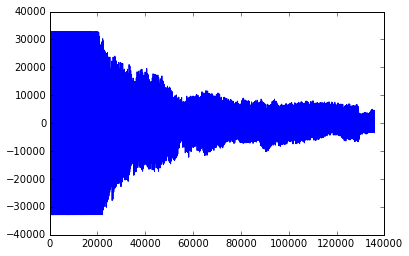

In [2]:
filename = "CG.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

pl.figure()
pl.plot(waveArray)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [5]:
# calculates and returns spectrogram of 
def get_wave(filename):
    w = wave.open(filename,"rb")
    waveParams = w.getparams()
    s = w.readframes(waveParams[3])
    w.close()
    waveArray = np.fromstring(s, np.int16)
    return waveArray

# power spectrogram is the absolute value SQUARED of the stft
def get_spectrogram(stft):
    return np.abs(stft)**2

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(wave, win_size, overlap):
    # power sinbell analysis window
    win = power_sinebell(win_size, overlap)
    # make the frames
    frames, wave_pad = make_frames(wave, win, overlap)
    # fft, for each column
    stft = np.fft.fft(frames)
    # keep the spectrum associated with the positive frequencies (potentially times to the upper frequencies)
    if len(win)%2 == 0:
        stft = stft[:int(len(win)/2)+1]
    else:
        stft = stft[:int((len(win)+1)/2)]
    return stft, wave_pad
    
# create sinebell window of length win_size, with overlap, DONE
def sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )
    return win

# computes sinebell window with smooth edges, this should be an improvement
def power_sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )**2
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )**2
    return win

# x is the input signal, win is the analysis window, overlap
# returns frame matrix and padded input signal x_pad
def make_frames(x, win, overlap):
    win_len = win.shape[0]
    x_len = len(x)
    
    # number of frames
    num_frames = int(np.ceil((x_len + overlap)/(win_len - overlap)))
    
    # initializing zero padded signal
    pad_len = int(overlap + num_frames * (win_len - overlap))
    x_pad = np.zeros(pad_len)
    x_pad[overlap: overlap + x_len] = x
    
    # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_len - overlap)
    
    # initialize frames matrix
    frames = np.zeros((win_size, num_frames))
    for i in range(num_frames):
        frames[:,i] = (x_pad[frame_ind[i] : frame_ind[i] + win_size] * win)
    
    return frames, x_pad
    
def my_istft(stft, win_size, overlap):
    # power sinbell analysis window
    win = power_sinebell(win_size, overlap)
    (num_coeff, num_frames) = stft.shape
    
    # recover full stft by conjugate symmetry of the fourier expansion of real signals
    stft_full = np.zeros((win_size, num_frames), dtype = np.complex128)
    stft_full[:num_coeff,:] = stft
    
    # reasoning: stft[ num_coeff - 1] is the both the negative and positive Nyquist frequency if win_size is even
    # thus, we take the conjugate only of stft[ num_coeff - 2:0:-1 ]
    if win_size%2 == 0:
        stft_full[num_coeff:, :] = np.conj(stft[num_coeff-2:0:-1, :])
    else:
        stft_full[num_coeff:,:] = np.conj(stft[num_coeff-1:0:-1, :])
        
    # take inverse fft of recovered stft
    istft = np.fft.ifft(stft_full)
    # reconstruct padded signal by taking overlap into account
    x_pad = overlap_add(istft, win_size, overlap)
    return x_pad

def overlap_add(signal, win_size, overlap):
    
    win = power_sinebell(win_size, overlap)
    (temp, num_frames) = signal.shape

    if temp != win_size:
        print("Dimensions of ISTFT are wrong!")
    
    pad_len = overlap + num_frames * (win_size - overlap)
    x_pad = np.zeros(pad_len, dtype = np.complex128)
    
     # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_size - overlap)
    
    # do we really need the window again here?
    x_pad[frame_ind[0]:frame_ind[0] + win_size] = signal[:,0] * win
    for i in range(1,num_frames):
        x_pad[frame_ind[i]:frame_ind[i] + win_size] = x_pad[frame_ind[i]:frame_ind[i] + win_size] + signal[:,i] * win
    return x_pad

In [6]:
# epsilon divergence
def compute_obj(v,W,h,eps):
    whv = (np.dot(W,h) + eps)/(v + eps)
    div = whv - np.log(whv) - 1 
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    return grad

# important! input here has to be the matrix H, not the vector h_t
# this is because we need h_t but also h_(t-1) and h_(t+1)
# ind_t is the index of h_t in H
# lambda is the smoothness constant
def compute_smooth_obj(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # compute regular objective
    # maybe doing this direct instead of the function call is faster:
    # whv = (np.dot(W,h) + eps)/(v + eps)
    # div = whv - np.log(whv) - 1 
    div = compute_obj(v,W,h,eps)
    
    # compute smoothness terms
    s1 = H[:,ind_t]/H[:,ind_t-1]
    s2 = H[:,ind_t]/H[:,ind_t+1]
    sm = s1 - np.log(s1) - 1
    sm += s2 - np.log(s2) - 1
    # returning properly scaled smooth objective
    return div + lamb * np.sum( sm )
    
# input parameters as above
def compute_smooth_grad(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # calculates gradient of regular divergence
    div_grad = compute_grad(v,W,h,eps)

    # calculating gradient of smoothness term
    sm_grad = 1/H[:,ind_t-1] + 1/H[:,ind_t+1] - 2/H[:,ind_t]
    sm_grad = sm_grad.reshape(sm_grad.shape[0],1)
    
    # returning properly scaled gradient of smooth objective 
    return div_grad + lamb * sm_grad
    

In [7]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
    
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[ 21.66927088]
 [ 12.55778371]]
[[ 21.6692726 ]
 [ 12.55778406]]


In [8]:
# second grad checker for smooth objective functions: Works!
def grad_checker(v,W,H,ind_t,lamb,eps):
    eps_dif = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(H[:,ind_t].shape)
    for i in range(k):
        ei = np.zeros(H.shape)
        ei[i,ind_t] = eps_dif
        t_grad[i] = (compute_smooth_obj(v,W,H+ei,ind_t,lamb,eps) - compute_smooth_obj(v,W,H-ei,ind_t,lamb,eps)) / (2*eps_dif)
    print(t_grad)
    print(compute_smooth_grad(v,W,H,ind_t,lamb,eps))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 3),1,1,1e-12)

[-10.41378977   3.68336347]
[[-10.41332912]
 [  3.68346239]]


In [9]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
  
    beta = 0.5 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-4 # optimization precision
    n = 1e-1 #initial step size
    
    h = np.random.rand(2, 1)
    
    obj = [None]*max_iter
    
    max_backstep = 100 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        n = 1/beta*n # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - n * grad < 0)  and t < max_backstep ):
            t += 1
            n = beta * n
    
        new_obj = compute_obj(v,W,(h - n*grad),eps)
        while( new_obj > opt_prec * compute_obj(v,W,h,eps) and t < max_backstep):
            t += 1
            n = beta * n
            new_obj = abs(compute_obj(v,W,(h - n*grad),eps))
                      
        h = h - n * grad # update h according to gradient step
        k += 1 # update gradient step counter
       
    h = h.reshape(h.shape[0],)
    return h, obj[0:int(k)]

h, obj = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)


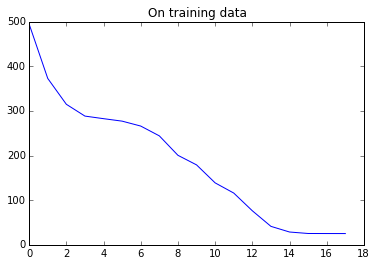

In [10]:
index = [i for i in range(10)]
plt.title("On training data")
plt.plot([i for i in range(len(obj))], obj)


In [38]:
def online_nmf(spectrum, W, H,A, B, rho, beta, eta, eps):
   
    H = H.T
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)
    
    t = 1
    W_old = W
    k = W.shape[1]
    h = np.random.rand(W.shape[1],)
    h_old = h
    
    
    while np.linalg.norm(W - W_old, ord = "fro") < eta:
        
        t = t+1 
        
        ind = random.randint(0, len(spectrum.T)-1)
        v = spectrum.T[ind]
        h_old = h
        h, obj = gradient_backtracking(v, W, h_old, 100, compute_grad, compute_obj, 1e-12)
       
        H[ind] = h
       
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(np.dot(((eps+v)/(eps+den)**2), h.T), np.dot(W.T,W))
        b += np.dot(1/den, h.T)
        
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            for i in range(k):
                s = np.sum(W[:,i])
                W[:,i] = W[:,i]/s
                A[:,i] = A[:,i]/s
                B[:,i] = B[:,i]*s
                print(i)
                
        if t > 500:
            print(W.shape)
            break

    print(t)
    return W, H.T


In [40]:
eps = 1e-12
v = spectrum.T[0]
K = 2
W = np.random.rand(spectrum.shape[0],K)
H = np.zeros((K, spectrum.shape[1]))

A = np.zeros(W.shape)
B = np.zeros(W.shape)


W, H = online_nmf(spectrum, W, H, A, B, 0.5, 100, 1e-12, eps)

0
1
100


In [81]:
W.shape

(129, 2)

In [82]:
H.shape

(2, 1060)

In [83]:
spectrum.shape

(129, 1060)

In [94]:
l_win = 256
overlap = lwin/2
N = spectrum.shape[1]
Tpad = int(l_win + (N-1)*(l_win-overlap))

c = np.zeros((K,Tpad))
V = np.dot(W, H)

In [98]:
def istft(stft, window, overlap):
    W = len(window)
    
    if W % 2 == 0:
        stft = [stft, stft[W/2:-1:2,:].conj()]
    else:
        stft = [stft, stft[(W+1)/2:-1:2].conj()]
        
    istft = np.fft.ifftn(stft)
    
    xpad = cf_overlap_add(ISTFT,SY_WINDOW,OVERLAP)